# Data Preparation

In [3]:
#Import package
import pandas as pd


In [4]:
# Import data
buku = pd.read_csv("https://raw.githubusercontent.com/aldizzaldi/melawanBurnout/master/dataset/books.csv")

In [5]:
buku.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


# EDA

In [6]:
buku.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


Cek apakah ada empty/missing value

In [7]:
buku.isna().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

## Melengkapi original_publication_year

In [8]:
missing_pubyear_id = buku[buku['original_publication_year'].isna()]['goodreads_book_id'].tolist()
missing_pubyear_id

[3609760,
 90072,
 856917,
 36,
 8724779,
 349254,
 9832370,
 5171894,
 17733861,
 1044141,
 9748274,
 48811,
 9528186,
 809849,
 765148,
 197436,
 351023,
 11318,
 6054190,
 1056627,
 6614886]

In [9]:
import requests
from bs4 import BeautifulSoup
import re

Ambil aja dari Goodreads, tapi enggak 100% yakin itu *original* publication year-nya. Gapapa lah.

In [10]:
def get_pub_year(i):
    url = f"https://www.goodreads.com/book/show/{i}"
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    try:
        pub_text = soup.select('div.row')[1].text.strip()
        pub_year = int(re.search(r'\d{4}', pub_text).group(0))
    except:
        pub_year = ''

    return pub_year

In [11]:
pub_year = []
for id in missing_pubyear_id:
  pub_year.append(get_pub_year(id))
pub_year

KeyboardInterrupt: 

In [ ]:
buku.loc[buku['original_publication_year'].isna(), 'original_publication_year'] = pub_year
buku['original_publication_year'].isna().any()

## Melengkapi original title (dan isbn13?)

In [ ]:
buku.isna().sum()

Jumlah missing values `original_title` dan `isbn` sama, jadi mungkin berasal dari rows yang sama pula.

In [ ]:
missing_ori_title = buku.loc[buku['original_title'].isna(), :].goodreads_book_id
missing_ori_title

In [ ]:
missing_isbn13 = buku.loc[buku['isbn13'].isna(), :].goodreads_book_id
missing_isbn13

Ouh, ternyata lumayan beda. Oke, selesaikan terpisah.

In [ ]:
missing_ori_title = missing_ori_title.to_list()

In [ ]:
def get_ori_title(i):
  url = f"https://www.goodreads.com/book/show/{i}"
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
  html_page = requests.Session().get(url, headers=headers)
  soup = BeautifulSoup(html_page.content, 'html.parser')
  try:
      ori_title = soup.select('.infoBoxRowItem')[0].text.strip()
  except:
      ori_title = None
      
  return ori_title

585 kebanyakan? Saatnya threading!

In [ ]:
import concurrent.futures
import time
from tqdm import tqdm

In [ ]:
while buku['original_title'].isna().sum() > 0:
  missing_ori_title = buku.loc[buku['original_title'].isna(), :].goodreads_book_id.to_list()
  found_ori_title = ['' for x in missing_ori_title]

  with concurrent.futures.ThreadPoolExecutor() as executor:
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #   future = executor.map(get_songs, alphabets)
    #   songs_kapanlagi = [song for f in future for song in f]

    future = executor.map(get_ori_title, missing_ori_title)
    for i,f in enumerate(tqdm(future, total=len(missing_ori_title))):
      found_ori_title[i] = f
      time.sleep(1e-3)

  buku.loc[buku['original_title'].isna(), 'original_title'] = found_ori_title

  print(len(found_ori_title))
  print(buku['original_title'].isna().sum())

In [ ]:
buku.to_csv('buku_v2.csv', index=False)

from google.colab import files
files.download( 'buku_v2.csv' )

In [ ]:
missing_isbn13 = missing_isbn13.to_list()

In [ ]:
missing_isbn13[:5]

In [ ]:
def get_isbn13(i):
  url = f"https://www.goodreads.com/book/show/{i}"
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
  html_page = requests.Session().get(url, headers=headers)
  soup = BeautifulSoup(html_page.content, 'html.parser')
  try:
      isbn13 = soup.select('span', itemprop='isbn')
  except:
      isbn13 = None
      
  return isbn13

get_isbn13(missing_isbn13[2])

In [ ]:
while buku['isbn13'].isna().sum() > 0:
  missing_ori_title = buku.loc[buku['isbn13'].isna(), :].goodreads_book_id.to_list()
  found_ori_title = ['' for x in missing_ori_title]

  with concurrent.futures.ThreadPoolExecutor() as executor:
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #   future = executor.map(get_songs, alphabets)
    #   songs_kapanlagi = [song for f in future for song in f]

    future = executor.map(get_ori_title, missing_ori_title)
    for i,f in enumerate(tqdm(future, total=len(missing_ori_title))):
      found_ori_title[i] = f
      time.sleep(1e-3)

  buku.loc[buku['original_title'].isna(), 'original_title'] = found_ori_title

  print(len(found_ori_title))
  print(buku['original_title'].isna().sum())

Ternyata emang enggak semua buku ada isbn13-nya :/

Oke, bisa diabaikan.

In [ ]:
buku.isna().sum()

In [ ]:
buku[buku.language_code.isna()].goodreads_book_id.tolist()

# ML

In [13]:
#Import Data Ratings
import pandas as pd
rating=pd.read_csv("https://raw.githubusercontent.com/rahshabrina/goodbooks-10k/master/ratings.csv")

In [14]:
rating.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [15]:
rating.isna().any()

user_id    False
book_id    False
rating     False
dtype: bool

# Modelling

In [16]:
#Splitting Data

from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(rating, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (4781183, 3)
Shape of test data: (1195296, 3)


In [17]:
#Find the number of uniq items
nbook_id = rating.book_id.nunique()
nuser_id = rating.user_id.nunique()

In [18]:
#Embedding

import tensorflow.keras as tf
#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

In [29]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=2, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/2
74706/74706 [==============================] - 1526s 20ms/step - loss: 0.6779 - val_loss: 0.6960
Epoch 2/2
74706/74706 [==============================] - 1430s 19ms/step - loss: 0.6514 - val_loss: 0.6813


# Evaluating

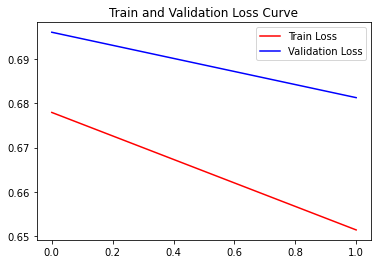

In [30]:
import matplotlib.pyplot as plt

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [31]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model\assets


# Predict

In [32]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [33]:
books_df_copy = buku.copy()
books_df_copy = books_df_copy.set_index("book_id")

In [41]:
#abaikan dulu yang ini

#b_id =list(rating.book_id.unique())
#b_id.remove(10000)
#dict_map = {}
#for i in b_id:
#    dict_map[i] = books_df_copy.iloc[i]['title']
    
#out_v = open('vecs.tsv', 'w')
#out_m = open('meta.tsv', 'w')
#for i in b_id:
#    book = dict_map[i]
#    embeddings = book_em_weights[i]
#    out_m.write(book + "\n")
#    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
#out_v.close()
#out_m.close()

In [37]:
import numpy as np
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[3.5995784],
       [3.3195167],
       [3.3065093],
       ...,
       [2.7334638],
       [2.9434018],
       [2.9735098]], dtype=float32)

In [38]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([ 479, 1534,  973, 2334,  975], dtype=int64)

In [39]:
web_book_data = buku[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

,book_id,title,image_url,authors
0,1,"The Hunger Games (The Hunger Games, #1)",https://images.gr-assets.com/books/1447303603m...,Suzanne Collins
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
2,3,"Twilight (Twilight, #1)",https://images.gr-assets.com/books/1361039443m...,Stephenie Meyer
3,4,To Kill a Mockingbird,https://images.gr-assets.com/books/1361975680m...,Harper Lee
4,5,The Great Gatsby,https://images.gr-assets.com/books/1490528560m...,F. Scott Fitzgerald


In [40]:
web_book_data.to_json(r'web_book_data.json', orient='records')

# Deployment

In [44]:
#xixiix
preda=pd.DataFrame(pred)
preda.to_json(r'predict0.json', orient='records')

In [49]:
fitur=[book_arr, user]
fitur_df=pd.DataFrame(fitur)
fitur_df.to_json(r'predict0.json', orient='records')

,0
0,3.599578
1,3.319517
2,3.306509
3,3.463844
4,2.984407
...,...
9994,3.957189
9995,3.967839
9996,2.733464
9997,2.943402
